# CENG 465 Homework 2: Malignant vs Bening Skin Cancer Clustering 

In [2]:
from glob import glob # take image paths

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # open cv for image manipulations

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering 
from skimage.color import rgb2gray
from scipy.cluster.hierarchy import dendrogram, ward  
from sklearn.decomposition import PCA, NMF 
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.neighbors import NearestNeighbors 
from sklearn.model_selection import GridSearchCV # hyper parameter automization

import warnings 
from helpers import load_images, mean_filter, thresholding, create_dataframe, elbow

warnings.simplefilter('ignore') 

In [3]:
# getting the images 
mal_train = glob('data/train/malignant/*')
ben_train = glob('data/train/benign/*')

mal_images = glob('data/train/malignant/*')[:5]
ben_images = glob('data/train/benign/*')[:5]

In [4]:
# getting the images as blob 
mal_train_img = load_images(mal_train)
ben_train_img = load_images(ben_train)

mal_1 = load_images(mal_images)
ben_1 = load_images(ben_images)

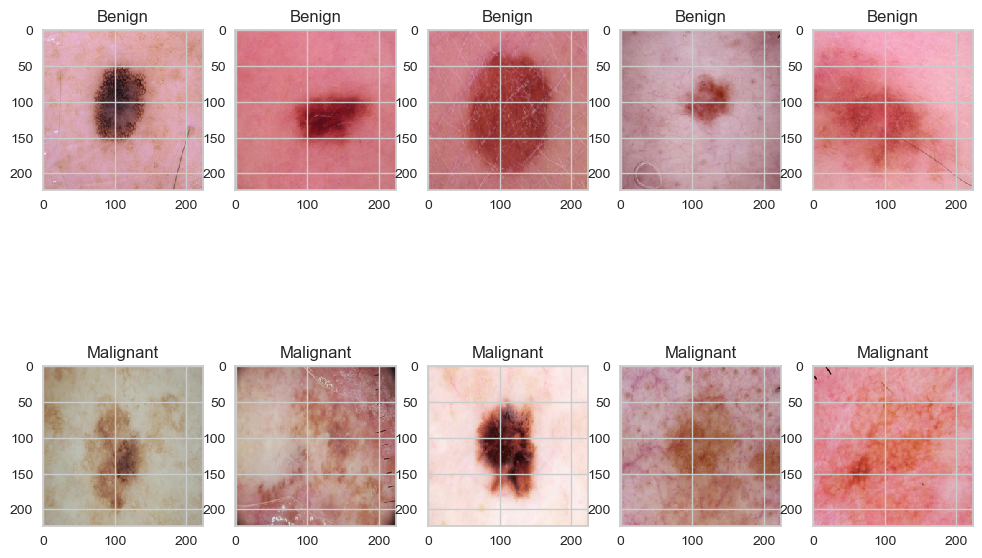

In [5]:
# Display first 5 images of skin cancers, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 2

for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    if i < 5:
        ax.title.set_text('Benign')
        plt.imshow(ben_1[i], interpolation='nearest')
    else:
        ax.title.set_text('Malignant')
        plt.imshow(mal_1[i-5], interpolation='nearest')
plt.show()

## Creating dataset
Create dataframe with malignant and bening cancer types where malignant class is 1 and bening class 0

In [6]:
_df_train = create_dataframe(mal_train_img, 1, ben_train_img, 0)

In [7]:
df_train = _df_train.copy()

In [8]:
df_train.head()

,Data,Target
0,"[[[162, 136, 113], [159, 133, 110], [156, 130,...",1
1,"[[[55, 23, 26], [60, 28, 29], [65, 33, 34], [7...",1
2,"[[[220, 206, 205], [241, 216, 212], [240, 212,...",1
3,"[[[194, 153, 169], [191, 148, 165], [186, 142,...",1
4,"[[[157, 113, 128], [160, 110, 122], [160, 108,...",1


## Describe the shape and features of the dataset

In [9]:
print("######## Number of samples ########")
print(df_train.shape[0])
print("######## Number of features ########")
print(df_train.shape[1])
print("######## Number of target classes ########")
print(df_train.Target.nunique())
print("######## Number of each classes in data ########")
print(df_train.groupby("Target").count(), "\n\nwhere\nclass 0 assigned to Bening\nclass 1 assigned to Malignant")

######## Number of samples ########
2637
######## Number of features ########
2
######## Number of target classes ########
2
######## Number of each classes in data ########
        Data
Target      
0       1440
1       1197 

where
class 0 assigned to Bening
class 1 assigned to Malignant


## Image Preprocessing
We apply some preprocessing steps for enhance image quality
To accomplish this task we do:
* RGB image to grayscale
* Applying mean filter for noise removing
* Applying Otsu Thresholding

In [10]:
# Apply gray scaling to the images
df_train.Data = df_train.Data.apply(lambda x: rgb2gray(x))

In [11]:
# Apply Mean blur for noise removal
df_train.Data = df_train.Data.apply(lambda x: mean_filter(x, 15))

In [12]:
df_train.Data.head()

0    [[137, 138, 138, 138, 138, 137, 137, 137, 136,...
1    [[87, 90, 92, 94, 96, 98, 100, 102, 104, 106, ...
2    [[221, 220, 220, 220, 220, 220, 220, 219, 219,...
3    [[157, 157, 158, 158, 158, 159, 159, 159, 160,...
4    [[151, 149, 149, 148, 146, 145, 145, 145, 145,...
Name: Data, dtype: object

In [13]:
df_train.Data = df_train.Data.apply(lambda x: thresholding(x))

In [14]:
df_train.Data.isnull().any()

False

Text(0.5, 1.0, 'After Segmentation')

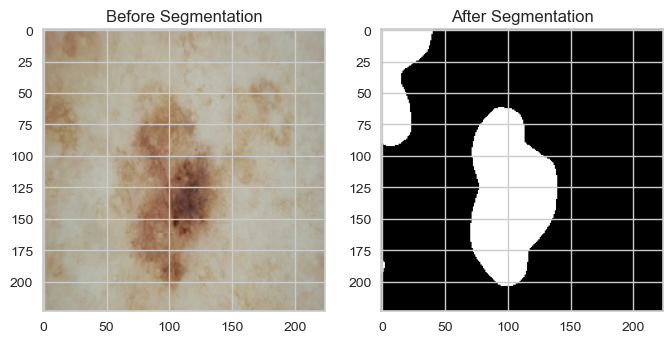

In [15]:
plt.subplot(1,2,1)
plt.imshow(_df_train.Data[0])
plt.title("Before Segmentation")
plt.subplot(1,2,2)
plt.imshow(df_train.Data[0])
plt.title("After Segmentation")

## Experimental Setup

In [16]:
X_cancer = df_train.Data.values
y_cancer = df_train.Target.values

In [17]:
X_cancer[0]

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [18]:
# Flatten the image for the algorithms
X_cancer_flat = [image.flatten() for image in df_train.Data.values]

In [19]:
X_cancer_flat[0]

array([False, False, False, ...,  True,  True,  True])

In [20]:
print("Image pixel size:", len(X_cancer_flat[0]))

Image pixel size: 50176


In [21]:
# PCA
# Testing pca within different component sizes and whiten option
pca_whiten = PCA(n_components=100, whiten=True, random_state=0).fit(X_cancer_flat)
reduced_data_whiten = pca_whiten.transform(X_cancer_flat)

pca_500 = PCA(n_components=500, random_state=0).fit(X_cancer_flat)
reduced_data_500 = pca_500.transform(X_cancer_flat)

pca_100 = PCA(n_components=100, random_state=0).fit(X_cancer_flat)
reduced_data_100 = pca_100.transform(X_cancer_flat)

pca_10 = PCA(n_components=10, random_state=0).fit(X_cancer_flat)
reduced_data_10 = pca_10.transform(X_cancer_flat)

In [22]:
# NMF
nmf = NMF(n_components=100, random_state=0).fit(X_cancer_flat)
reduced_data_nmf = nmf.transform(X_cancer_flat)

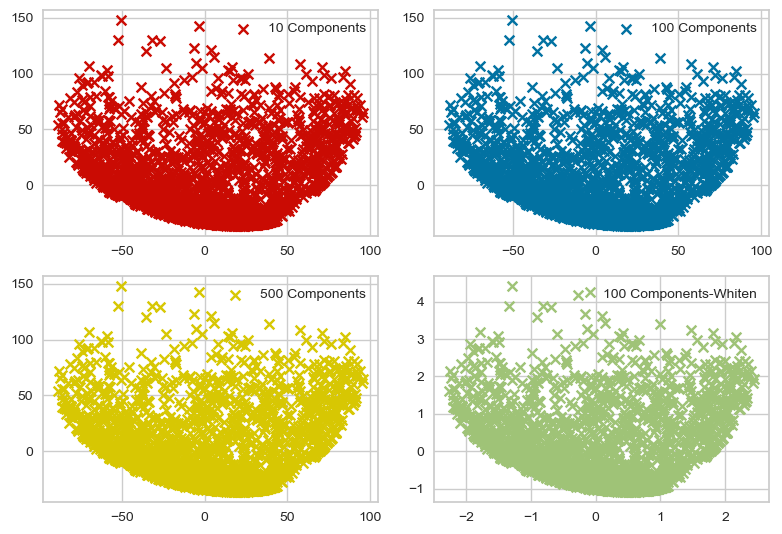

In [24]:
# Plotting different component sizes
plt.subplot(2,2,1)
plt.scatter(reduced_data_10[:, 0], reduced_data_10[:, 1], label='10 Components', c='r', marker='x')
plt.legend()
plt.subplot(2,2,2)
plt.scatter(reduced_data_100[:, 0], reduced_data_100[:, 1], label='100 Components', c='b', marker='x')
plt.legend()
plt.subplot(2,2,3)
plt.scatter(reduced_data_500[:, 0], reduced_data_500[:, 1], label='500 Components', c='y', marker='x')
plt.legend()
plt.subplot(2,2,4)
plt.scatter(reduced_data_whiten[:, 0], reduced_data_whiten[:, 1], label='100 Components-Whiten', c='g', marker='x')
plt.legend()
plt.tight_layout();

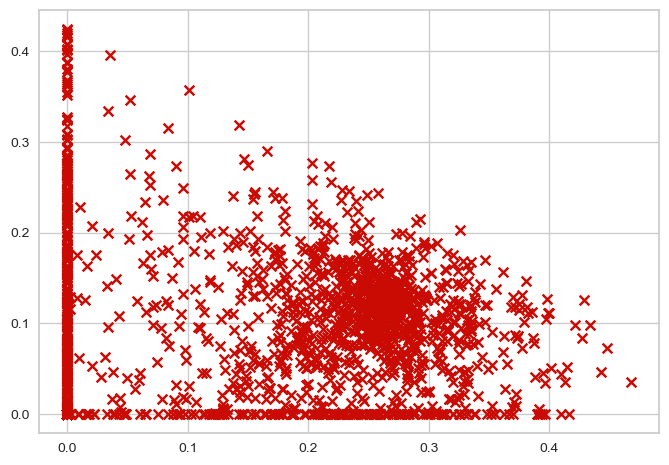

In [25]:
# NMF plot
plt.scatter(reduced_data_nmf[:, 0], reduced_data_nmf[:, 1], label='NMF 100 Components', c='r', marker='x')

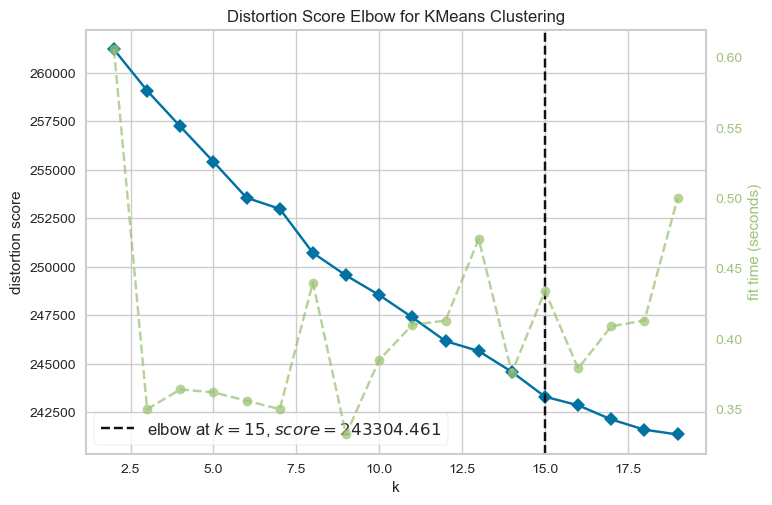

In [26]:
k_whiten = elbow(reduced_data_whiten)

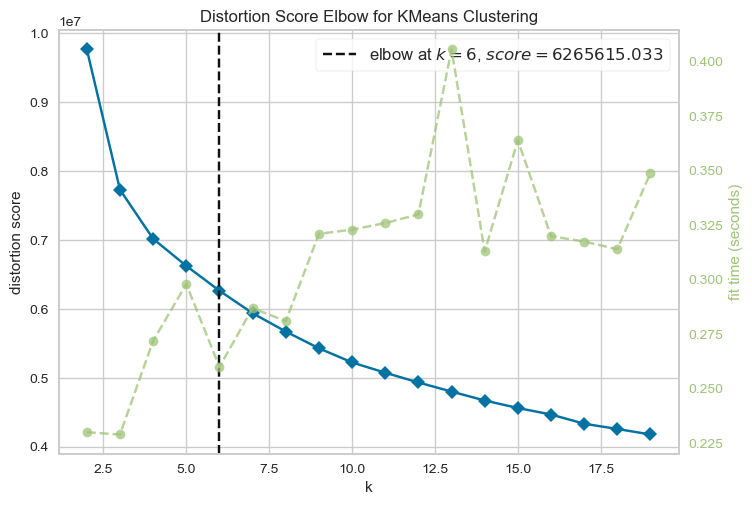

In [27]:
k_10 = elbow(reduced_data_10)

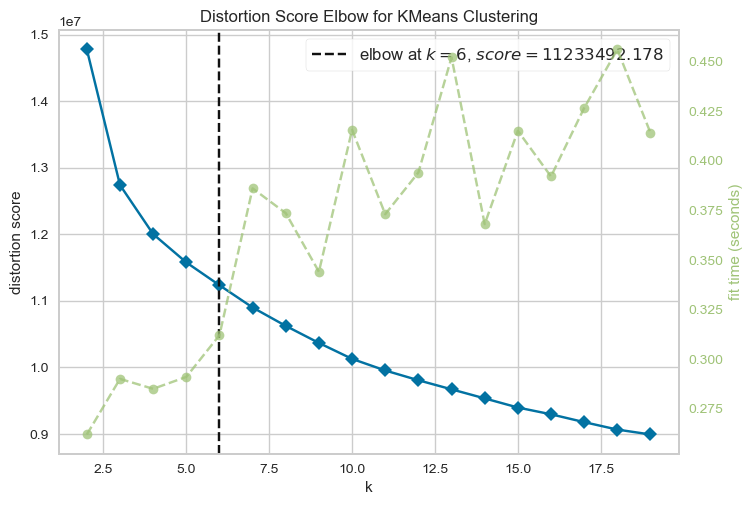

In [28]:
k_100 = elbow(reduced_data_100)

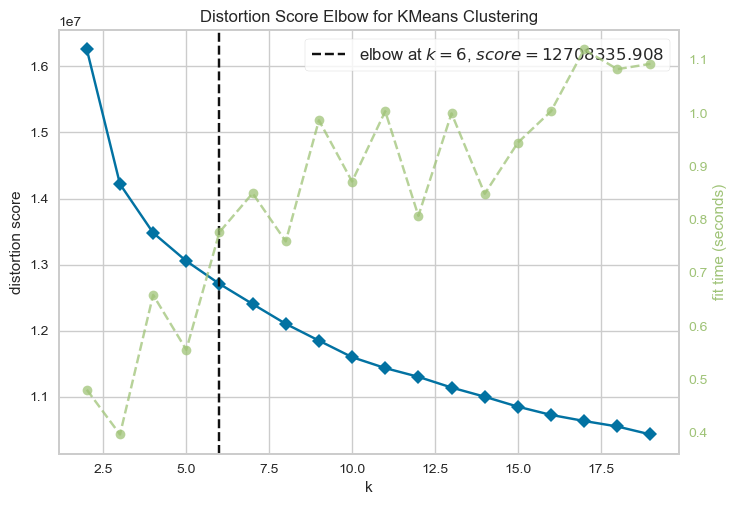

In [29]:
k_500 = elbow(reduced_data_500)

### KMeans
We experiment different k score according to elbow method. But for this scenario we only have 2 clusters or labels.

In [30]:
num_clusters = 2

In [31]:
km= KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
labels_km = km.fit_predict(reduced_data_whiten)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [ 805 1832]


In [32]:
km= KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
labels_km = km.fit_predict(reduced_data_100)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [1454 1183]


In [33]:
km_nmf = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
labels_km_nmf = km.fit_predict(reduced_data_nmf)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km_nmf)))

Cluster sizes k-means: [1462 1175]


In [ ]:
def report(y_cancer, labels_km):
    # y_cancer is a ground truth labels and 'labels_xx' are the cluster labels
    conf_matrix = confusion_matrix(y_cancer, labels_km)
    classification_rep = classification_report(y_cancer, labels_km)
    
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_rep)

In [35]:
report(y_cancer, labels_km)

Confusion Matrix:
[[824 616]
 [630 567]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1440
           1       0.48      0.47      0.48      1197

    accuracy                           0.53      2637
   macro avg       0.52      0.52      0.52      2637
weighted avg       0.53      0.53      0.53      2637



In [36]:
report(y_cancer, labels_km_nmf)

Confusion Matrix:
[[594 846]
 [868 329]]

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.41      0.41      1440
           1       0.28      0.27      0.28      1197

    accuracy                           0.35      2637
   macro avg       0.34      0.34      0.34      2637
weighted avg       0.35      0.35      0.35      2637



As we can see from the outputs PCA and NMF gives similar values. However, when we test them with the classification report we can see the results of false-true values on NMF more than PCA. So for the KMeans we choose PCA with 100 components

### DBScan

In [37]:
dbscan = DBSCAN()
labels_db = dbscan.fit_predict(reduced_data_100)
print("Unique labels: {}".format(np.unique(labels_db)))

Unique labels: [-1]


In [38]:
labels_db_nmf = dbscan.fit_predict(reduced_data_nmf)
print("Unique labels: {}".format(np.unique(labels_db_nmf)))

Unique labels: [0]


Compute data proximity from each other using Nearest Neighbours

In [39]:
neighb = NearestNeighbors(n_neighbors=2) 
nbrs=neighb.fit(reduced_data_100) 
distances,indices=nbrs.kneighbors(reduced_data_100)

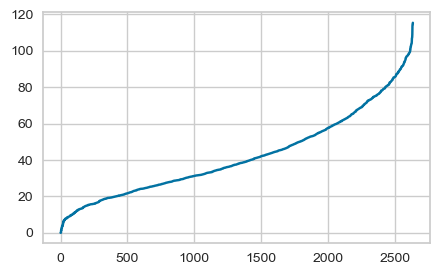

In [40]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) 
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3)
plt.plot(distances) 
plt.show()

In [41]:
neighb = NearestNeighbors(n_neighbors=2) 
nbrs=neighb.fit(reduced_data_nmf) 
distances,indices=nbrs.kneighbors(reduced_data_nmf)

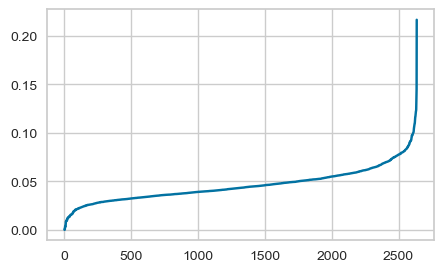

In [42]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) 
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3)
plt.plot(distances) 
plt.show()

In [55]:
for eps in [85, 86, 87, 88, 90]:
 print("\neps={}".format(eps))
 dbscan = DBSCAN(eps=eps, min_samples=3, metric='euclidean', n_jobs=-1)
 labels = dbscan.fit_predict(reduced_data_100)
 print("Clusters present: {}".format(np.unique(labels)))
 print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=85
Clusters present: [-1  0  1  2  3]
Cluster sizes: [ 153 2470    4    7    3]

eps=86
Clusters present: [-1  0  1  2]
Cluster sizes: [ 138 2492    4    3]

eps=87
Clusters present: [-1  0  1]
Cluster sizes: [ 130 2504    3]

eps=88
Clusters present: [-1  0]
Cluster sizes: [ 120 2517]

eps=90
Clusters present: [-1  0]
Cluster sizes: [ 101 2536]


In [44]:
for eps in [85, 86, 87, 88, 90]:
 print("\neps={}".format(eps))
 dbscan = DBSCAN(eps=eps, min_samples=3, metric='euclidean', n_jobs=-1)
 labels_nmf = dbscan.fit_predict(reduced_data_nmf)
 print("Clusters present: {}".format(np.unique(labels_nmf)))
 print("Cluster sizes: {}".format(np.bincount(labels_nmf + 1)))


eps=85
Clusters present: [0]
Cluster sizes: [   0 2637]

eps=86
Clusters present: [0]
Cluster sizes: [   0 2637]

eps=87
Clusters present: [0]
Cluster sizes: [   0 2637]

eps=88
Clusters present: [0]
Cluster sizes: [   0 2637]

eps=90
Clusters present: [0]
Cluster sizes: [   0 2637]


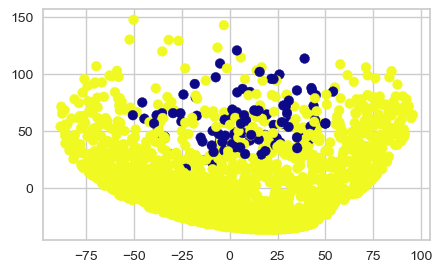

In [45]:
# Plot the clusters
plt.scatter(reduced_data_100[:, 0], reduced_data_100[:,1], c = labels, cmap= "plasma")
plt.show()

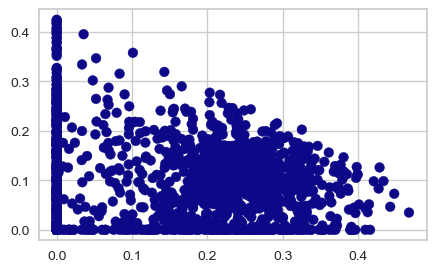

In [46]:
# Plot the clusters
plt.scatter(reduced_data_nmf[:, 0], reduced_data_nmf[:,1], c = labels_nmf, cmap= "plasma")
plt.show()

Even with NearestNeighbor method we cannot get the close results when using DBScan. So we eliminate this algorithm.

### Agglomerative Clustering

In [47]:
agglomerative = AgglomerativeClustering(n_clusters=2)
labels_agg = agglomerative.fit_predict(reduced_data_whiten)
print("Cluster sizes agglomerative clustering: {}".format(
 np.bincount(labels_agg)))

Cluster sizes agglomerative clustering: [1160 1477]


In [48]:
labels_agg_nmf = agglomerative.fit_predict(reduced_data_nmf)
print("Cluster sizes with NMF agglomerative clustering: {}".format(
 np.bincount(labels_agg_nmf)))

Cluster sizes with NMF agglomerative clustering: [1460 1177]


Text(0, 0.5, 'Cluster distance')

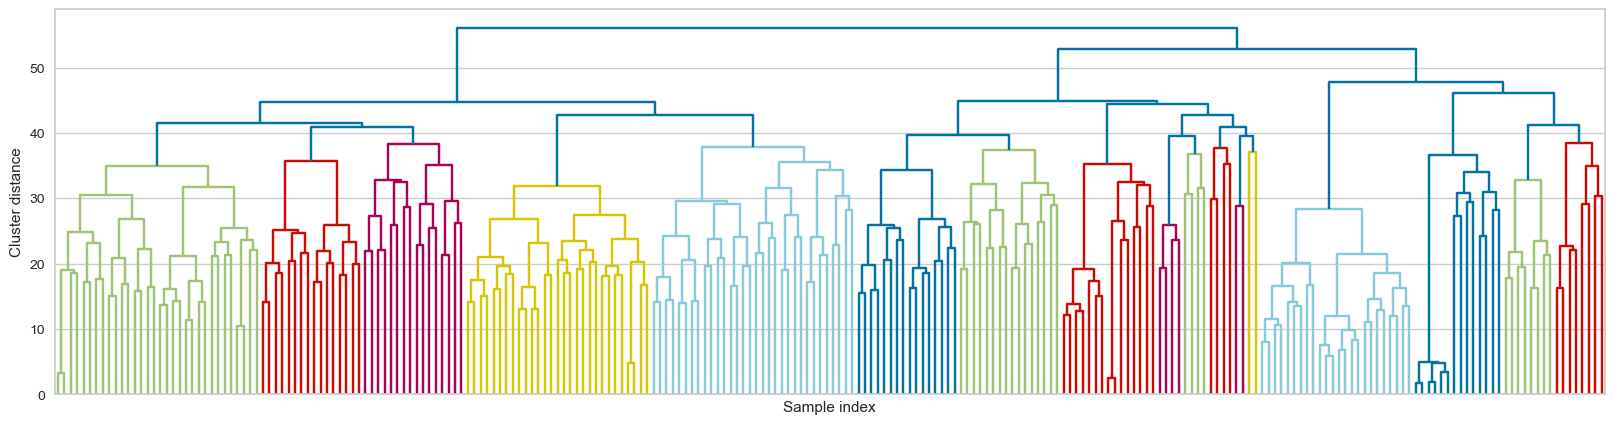

In [49]:
linkage_array = ward(reduced_data_whiten)
# now we plot the dendrogram for the linkage_array
# containing the distances between clusters
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

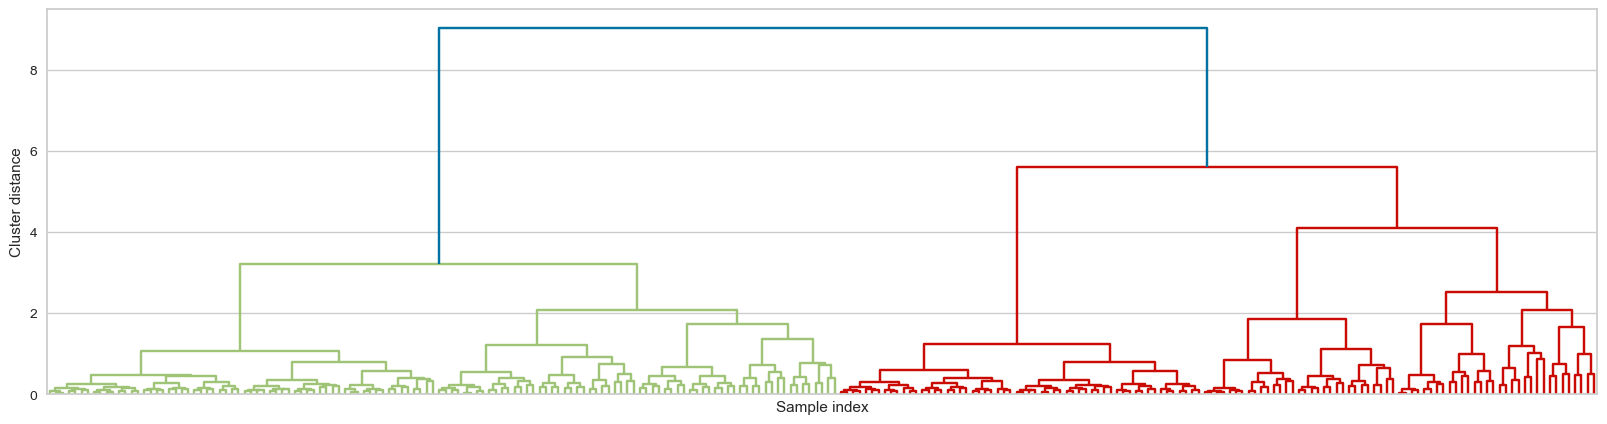

In [50]:
linkage_array = ward(reduced_data_nmf)
# now we plot the dendrogram for the linkage_array
# containing the distances between clusters
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

In [58]:
report(y_cancer, labels_agg_nmf)

Confusion Matrix:
[[601 839]
 [859 338]]

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.42      0.41      1440
           1       0.29      0.28      0.28      1197

    accuracy                           0.36      2637
   macro avg       0.35      0.35      0.35      2637
weighted avg       0.36      0.36      0.36      2637



Eventhough we have better precision score again the false trues values are too much for this context. So we eliminate this algorithm also.

## Improvements for the KMeans
At the end, we agreed on choosing KMeans over other algorithms. In the context of skin cancer, we have to predict every value by accurately. So that means we have to figure out how to converge the false-positive values to 0.

In [51]:
# we give different paramaters for k-means
kmeans_param_grid = {'init': ['k-means++', 'random'], 'max_iter': [300, 500, 1000]}

kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_grid_search = GridSearchCV(kmeans, param_grid=kmeans_param_grid, scoring="adjusted_rand_score", cv=5)
kmeans_grid_search.fit(reduced_data_100)

best_kmeans_params = kmeans_grid_search.best_params_
best_kmeans_model = kmeans_grid_search.best_estimator_

print(best_kmeans_params, best_kmeans_model)

{'init': 'k-means++', 'max_iter': 300} KMeans(n_clusters=2, n_init=10, random_state=0)


In [52]:
km = KMeans(n_clusters=2, random_state=0, n_init=10, init="k-means++", max_iter=300)
labels_km = km.fit_predict(reduced_data_100)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [1454 1183]


In [53]:
report(y_cancer, labels_km)

Confusion Matrix:
[[824 616]
 [630 567]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1440
           1       0.48      0.47      0.48      1197

    accuracy                           0.53      2637
   macro avg       0.52      0.52      0.52      2637
weighted avg       0.53      0.53      0.53      2637

